In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip ./DHCD.zip -d ./raw_data/

Streaming output truncated to the last 5000 lines.
  inflating: ./raw_data/nhcd/nhcd/numerals/1/027_03.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/028_01.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/028_02.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/028_03.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/028_04.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/028_05.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/029_01.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/030_01.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/030_02.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/030_03.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/030_04.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/032_01.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/032_02.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/033_01.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/033_02.jpg  
  inflating: ./raw_data/nhcd/nhcd/numerals/1/034_01.jpg  
  inflating: ./raw_da

In [4]:
# loading the  the csv files

import pandas as pd

numerals = pd.read_csv('./raw_data/labels.csv', skiprows=lambda x: x not in list(range(2, 13)))
vowels = pd.read_csv('./raw_data/labels.csv', skiprows=lambda x: x not in list(range(17, 30)))
consonants = pd.read_csv('./raw_data/labels.csv', skiprows=lambda x: x not in list(range(34, 71)))

vowels['Class'] += 9
consonants['Class'] += 21

data_labels = pd.concat([numerals, vowels, consonants])
data_labels.to_csv('./devanagiri.csv', index=False)
classes = list(data_labels[['Class', 'Label']].Label)

In [5]:
data_labels = data_labels.reset_index(drop=True)
data_labels

,Class,Label,Devanagari Label,Phonetics
0,0,0,०,Śūn'ya
1,1,1,१,ēka
2,2,2,२,du'ī
3,3,3,३,tīna
4,4,4,४,cāra
5,5,5,५,pām̐ca
6,6,6,६,cha
7,7,7,७,sāta
8,8,8,८,āṭha
9,9,9,९,nau


In [6]:
#THE LABELLING CORRECTION, it was labelling the images consitently wrongly.

classes = [classes[k] for k in [int(j) for j in sorted([str(i) for i in range(57)])]]

In [7]:
# Make train and test data directories
# Copy the numerals, vowels and consonants to train directory as different folders.


import os

os.system('mkdir ./data ./data/train ./data/test')

#numerals
for index, row in numerals.iterrows():
    class_ = row['Class']
    os.system('cp -R ./raw_data/nhcd/nhcd/numerals/'+ str(class_) +' ./data/train/'+str(class_))

#vowels
for index, row in vowels.iterrows():
    class_ = row['Class']
    os.system('cp -R ./raw_data/nhcd/nhcd/vowels/'+ str(class_ - 9) +' ./data/train/'+str(class_))

#consonants
for index, row in consonants.iterrows():
    class_ = row['Class']
    os.system('cp -R ./raw_data/nhcd/nhcd/consonants/'+ str(class_ - 21) +' ./data/train/'+str(class_))

numerals, vowels, consonants = None, None, None

In [8]:
# Moving data to test folder (25%)
for class_ in os.listdir('./data/train'):
    os.system('mkdir ./data/test/'+class_)
    
    files = os.listdir('./data/train/'+class_)
    index = int((len(files)/100) * 25)
    files = files[index:]

    for file_ in files:
        os.system('mv ./data/train/'+class_+'/'+file_+' ./data/test/'+class_+'/'+file_)

# 1 - Model

In [9]:
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [10]:
DEVICE

'cuda'

In [11]:
# Data Loaders

target_transform = lambda x: int(x)
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.RandomRotation(20),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_set = datasets.ImageFolder('./data/train', transform=transform)
test_set = datasets.ImageFolder('./data/test', transform=transform)

train = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

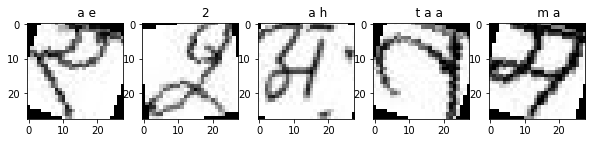

Images shape on batch size = torch.Size([32, 1, 28, 28])
Labels shape on batch size = torch.Size([32])


In [12]:
def train_imshow():
    # dataiter = iter(train)
    # images, labels = dataiter.next()
    images, labels = next(iter(train))
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)

    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i, 0], cmap='gray')
        ax.title.set_text(' '.join('%5s' % str(classes[labels[i]])))
    plt.show()

    print('Images shape on batch size = {}'.format(images.size()))
    print('Labels shape on batch size = {}'.format(labels.size()))

#sample train data
train_imshow()

# CNN MODEL BUILDING

In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=1, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(2592, 128)
        self.fc2 = nn.Linear(128, 58) 
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
                
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [25]:
#instantiate a model and move it to device
model = NeuralNetwork().to(DEVICE)


criterion = nn.CrossEntropyLoss() #loss function,  the difference between the predicted outputs and the actual outputs. 

# The objective of the optimizer is to minimize the loss function,
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM) #optimizer

In [26]:
# Training the model

EPOCHS = 100

for epoch in range(EPOCHS):
    running_loss = 0.0

    for i, data in enumerate(train, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % BATCH_SIZE == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

In [27]:
correct = 0
total = 0

with torch.no_grad():
    for data in test:
        images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 51 %


In [30]:
# sample predictions
predicted = []

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  
  for data in test:
    images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
    output = model(images)
    _, prediction = torch.max(output, 1)
    predicted.append(prediction)

labels, prediction

(tensor([17, 35, 16, 33, 45, 35, 18, 57, 48,  3, 18,  6, 26,  0, 32, 14],
        device='cuda:0'),
 tensor([17, 35, 49, 48, 34, 35, 35, 18, 32,  3, 42,  3, 26,  0, 37, 14],
        device='cuda:0'))

# 2 - Filter Visualization

In [31]:
import numpy as np

def plot_filters(weights):
    nplots = weights.shape[0] * weights.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    npimg = np.array(weights.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(weights[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg, cmap='gray')
            ax1.set_title(str(i) + ',' + str(j))
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [ ]:
#cnn1 kernels visualization
plot_filters(model.cnn1.weight.data.cpu())

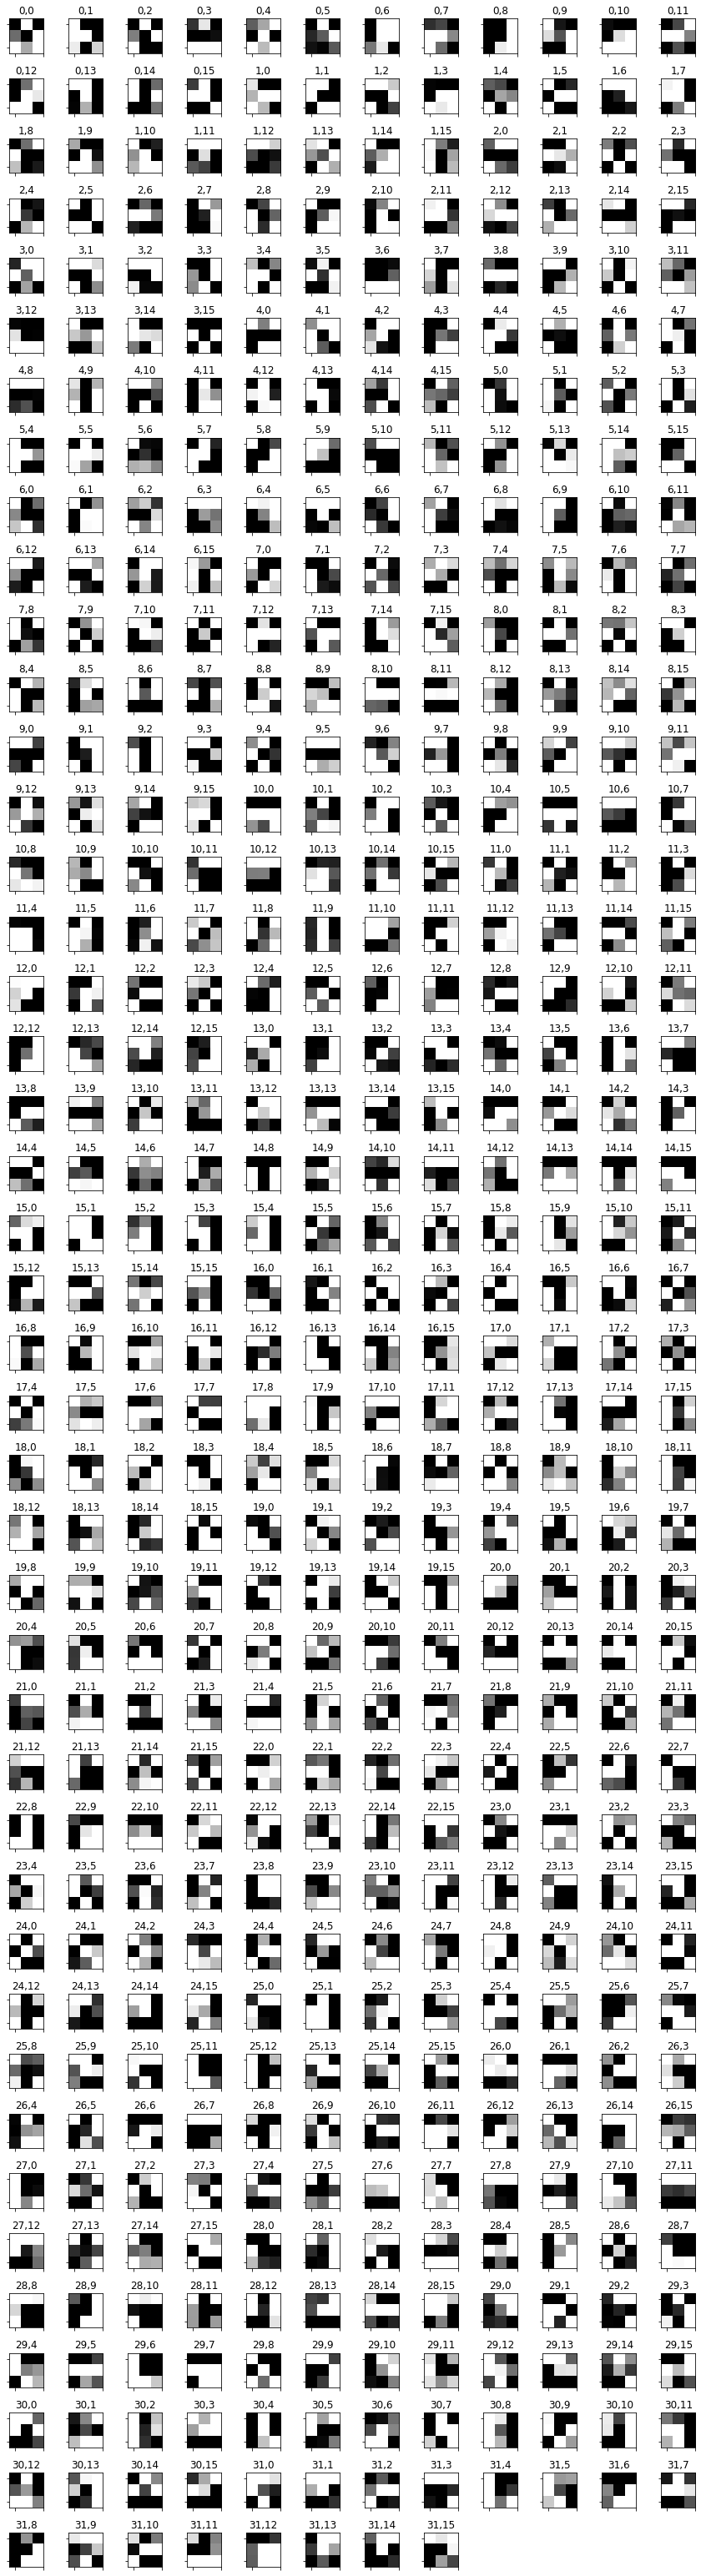

In [33]:
#cnn2 kernels visualization
plot_filters(model.cnn2.weight.data.cpu())

# 3 t-SNE Visualization

In [34]:
def gen_features():
    model.eval()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(test):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            targets_np = targets.data.cpu().numpy()

            outputs = model(inputs)
            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx+1) % 10 == 0) or (idx+1 == len(test)):
                print(idx+1, '/', len(test))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

10 / 782
20 / 782
30 / 782
40 / 782
50 / 782
60 / 782
70 / 782
80 / 782
90 / 782
100 / 782
110 / 782
120 / 782
130 / 782
140 / 782
150 / 782
160 / 782
170 / 782
180 / 782
190 / 782
200 / 782
210 / 782
220 / 782
230 / 782
240 / 782
250 / 782
260 / 782
270 / 782
280 / 782
290 / 782
300 / 782
310 / 782
320 / 782
330 / 782
340 / 782
350 / 782
360 / 782
370 / 782
380 / 782
390 / 782
400 / 782
410 / 782
420 / 782
430 / 782
440 / 782
450 / 782
460 / 782
470 / 782
480 / 782
490 / 782
500 / 782
510 / 782
520 / 782
530 / 782
540 / 782
550 / 782
560 / 782
570 / 782
580 / 782
590 / 782
600 / 782
610 / 782
620 / 782
630 / 782
640 / 782
650 / 782
660 / 782
670 / 782
680 / 782
690 / 782
700 / 782
710 / 782
720 / 782
730 / 782
740 / 782
750 / 782
760 / 782
770 / 782
780 / 782
782 / 782


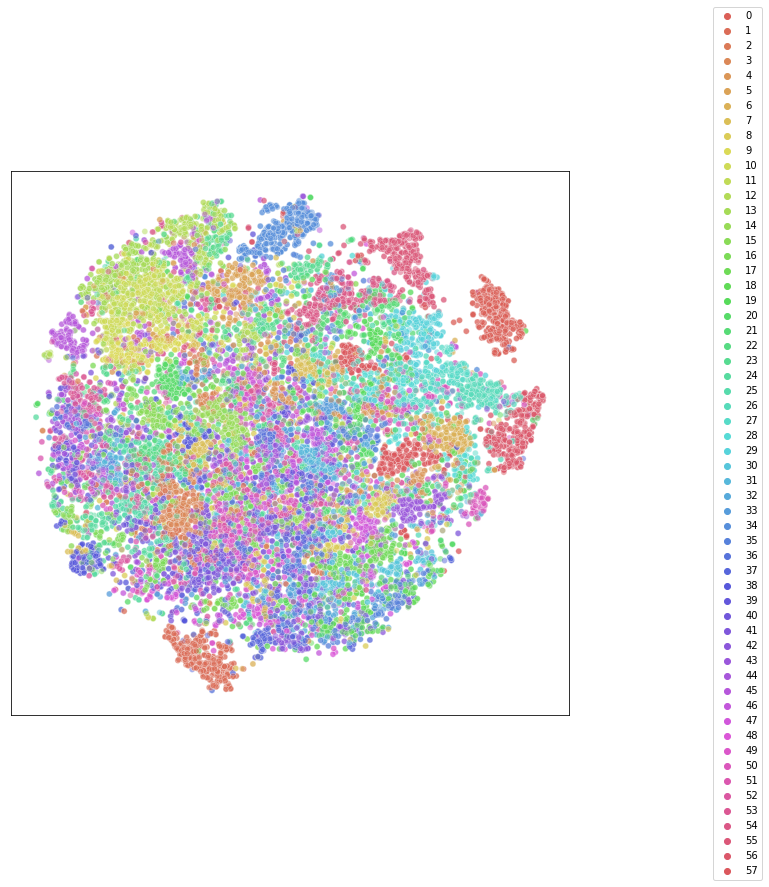

In [35]:
import seaborn as sns
from sklearn.manifold import TSNE

def tsne_plot(targets, outputs):
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(x='x',
                    y='y',
                    hue='targets',
                    palette=sns.color_palette('hls', 58),
                    data=df,
                    marker='o',
                    legend='full',
                    alpha=0.5)
    
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

targets, outputs = gen_features()
tsne_plot(targets, outputs)